<h1><center>Bank Transactions Analysis for FY2021-2022</center></h1>

The notebook contains different analysis:

- [Balance Trend Analysis](#balance-trend-across-fy-2021-22)
- [UPI](#usage-of-upi-platforms)
- [Expense Analysis](#expense-analysis)
- [Spending Behaviour Analysis using Clustering](#spending-behaviour-clustering)
- [Investment Analysis](#investment-analysis)
- [Seasonality of Expenses](#seasonality-analysis-of-expenses)


<span style="color: red;"><b>Important:</b></span>

- This notebook utilises the *config_bank.yml* file to store a lot of hardcoded variables. Refer to the *config_bank.yml* for making any changes
- The *config_bank.yml* shoud be kept in the **same working directory** as this notebook.
- If the path is changed, make sure to change the value in the *load_config* function. 


In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from re import search
from yaml import safe_load
from warnings import filterwarnings

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

filterwarnings('ignore')

CUSTOM FUNCTIONS

In [2]:
def load_config(file_path):
    with open(file_path, 'r') as f:
        return safe_load(f)

def create_error_file(file_path):
    with open(file_path,'w') as f:
        f.write()
        
def detect_transaction(remark):
    """
    This function is used to detect what kind of transaction has occured - card, NEFT, UPI etc
    The key value pairs for these are stored in the config_bank.yml document.
    """
    patterns = config['pattern']
    error_remarks = []
        
    for k,v in patterns.items():
        try:
            # match=  re.search(v,remark)
            match =  search(v,remark)
            if match:
                return k
        except Exception as e:
            error_remarks.append(remark)                      
            if error_remarks:
                with open("error_log.txt","w") as log_file:
                    log_file.write("\n".join(error_remarks))                    
    return None

def get_upi_platform(remark):
    """
    This function is used to acquire the UPI platform that has been used. 
    This platforms and it's corresponding UPI pattern is mentioned in the config_bank.yml file
    """    
    error_remarks = []
    for k,v in upi_platforms.items():
        try:
            # match=  re.search(k,remark)
            match =  search(v,remark)
            if match:
                return v
        except Exception as e:
            pass
    return None   


## Get the different values from the configuration file.
config = load_config("config_bank.yml")    
seed = config.get("seed")
date_cols = config.get('date_columns')
upi_platforms = config.get('upi_platform')
months = config.get("months")
expense_cols = config.get("expense_columns")
tnx_date = config.get("tnx_date")

In [3]:
# Reading the data
data = pd.read_excel("data.xlsx",sheet_name="Sheet1")
data = data.drop(["S No."],axis=1)

### Feature Engineering

In [4]:
# Convert to datetime.
date_cols = ["Value Date","Transaction Date"]
data[date_cols] = data[date_cols].apply(pd.to_datetime, format='%d/%m/%Y')

# Get Day and Month
data["Day"] = data[tnx_date].dt.strftime('%d')
data["Month"] = data[tnx_date].dt.month_name()

# Transaction Type
data["tnx_type"] = data["Transaction Remarks"].apply(detect_transaction)

# UPI platform
data["upi_platform"] = data["Transaction Remarks"].apply(get_upi_platform)

### Balance Trend across FY 2021-22

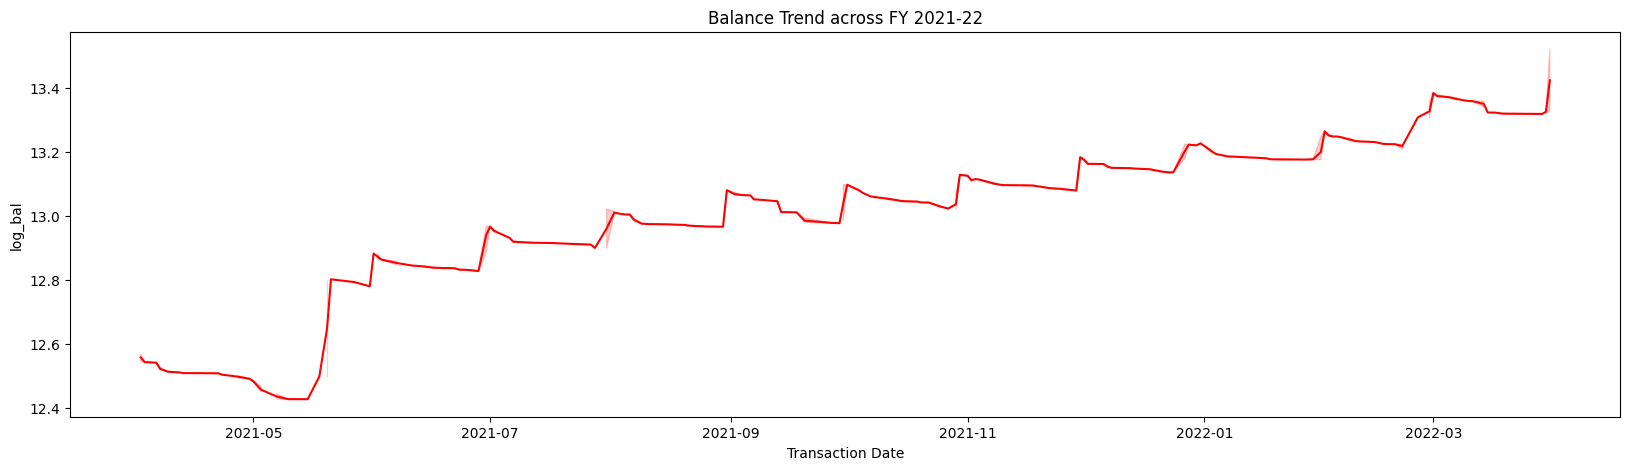

In [5]:
## Balance Analysis code:

df = data[["Transaction Date","Balance"]]
df["log_bal"] = np.log(df.Balance)
plt.figure(figsize=(20,5))
sns.lineplot(x='Transaction Date',y="log_bal",data=df,linestyle='-',color='red')
plt.title("Balance Trend across FY 2021-22")
plt.show();

<h4>Inference:</h4>
Well, since I was stuck at home in COVID, there was not too many expenses and thus my savings went on increasing....till, well 2022 😵‍💫😢😭.<br>
That's another story!

### Usage of UPI Platforms

My primary method of expenditure is UPI. I almost use it for everything - to an extent that I had forgotten my card pin. <br>
Dependence on one platform is not good.  As they say,
>Don't put all your eggs in the same basket

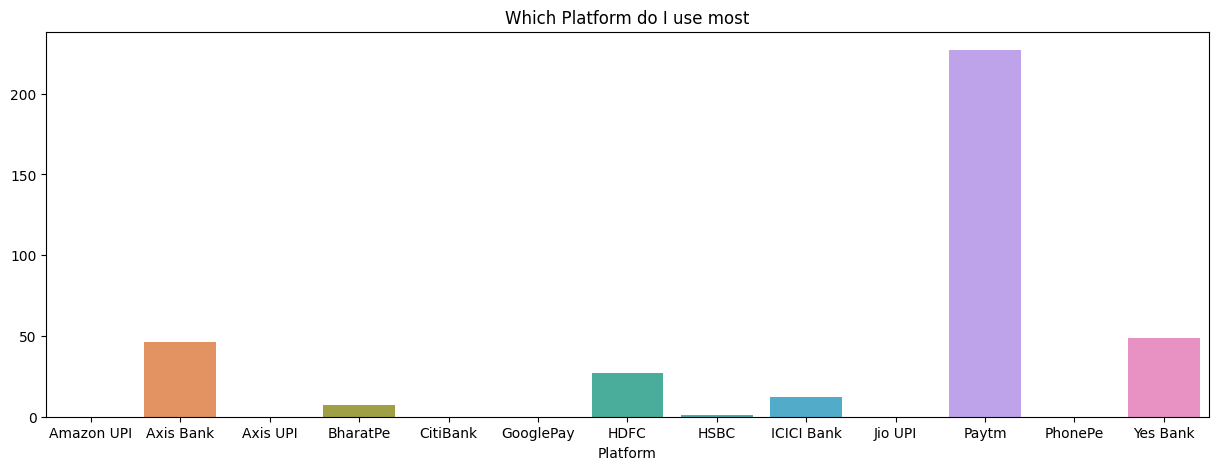

In [6]:
platforms = sorted(list(set(upi_platforms.values())))

plt.figure(figsize=(15,5))
sns.countplot(x=data["upi_platform"],order=platforms)
plt.title("Which Platform do I use most")
plt.ylabel("")
plt.xlabel("Platform")
plt.show();

Inference:<br>
The usage of Paytm dwarfs nearly usage of my other platforms. 
-  I only use Jio for paying Wifi bills so that is only 1 transaction in the month.
- Similarly, Axis, Citi - There are the platforms on which transactions have occured - I need not have used them.


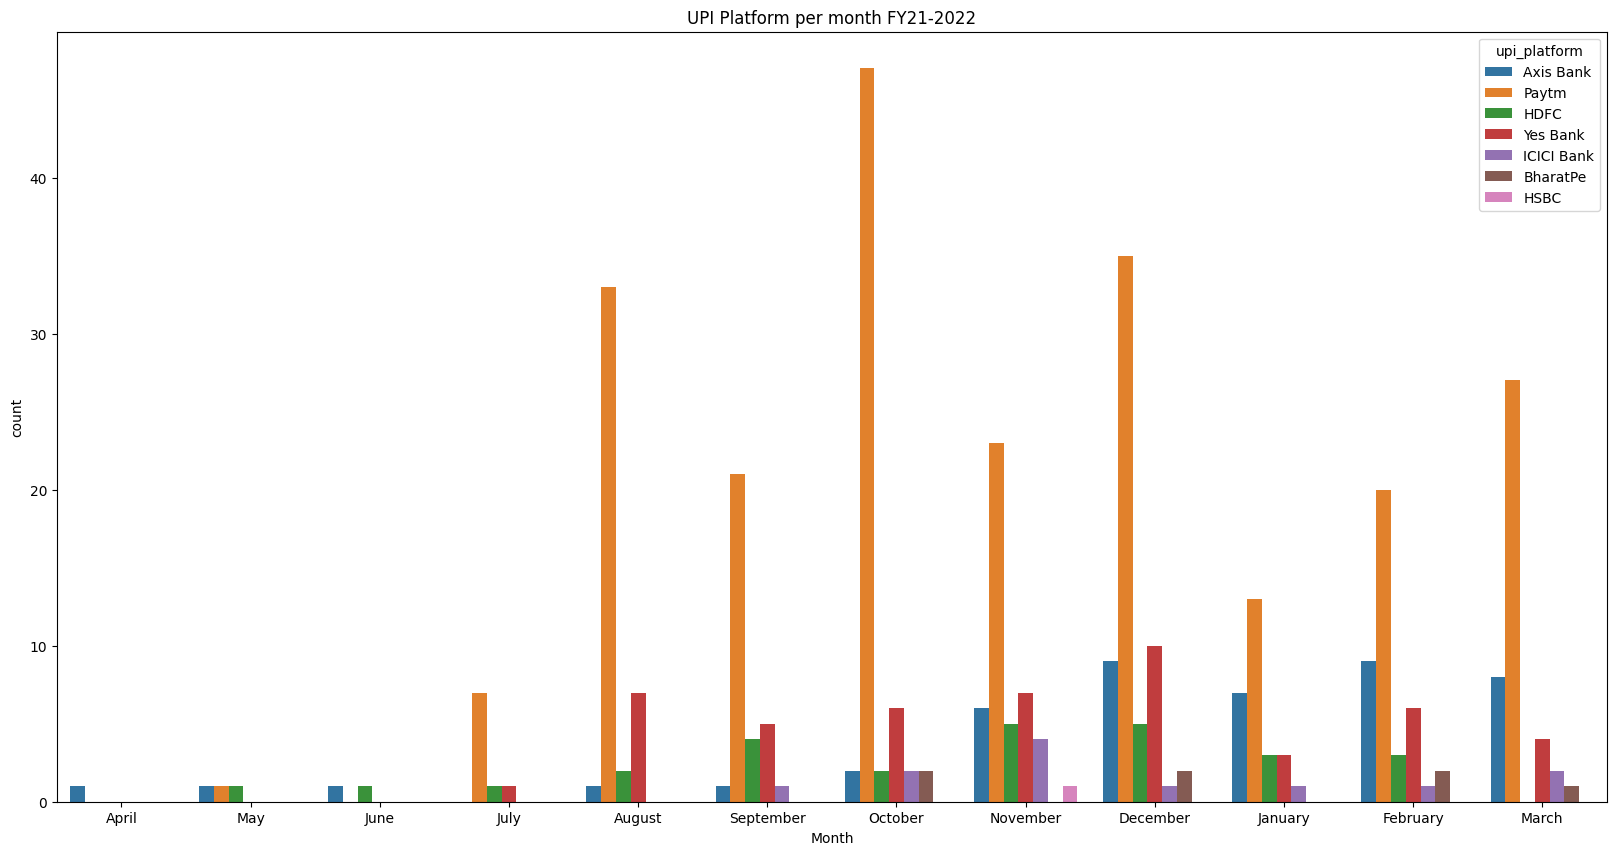

In [7]:
plt.figure(figsize=(20,10))
sns.countplot(x='Month',data=data,hue='upi_platform',order=months)
plt.title("UPI Platform per month FY21-2022")
plt.show();

---

## Expense Analysis

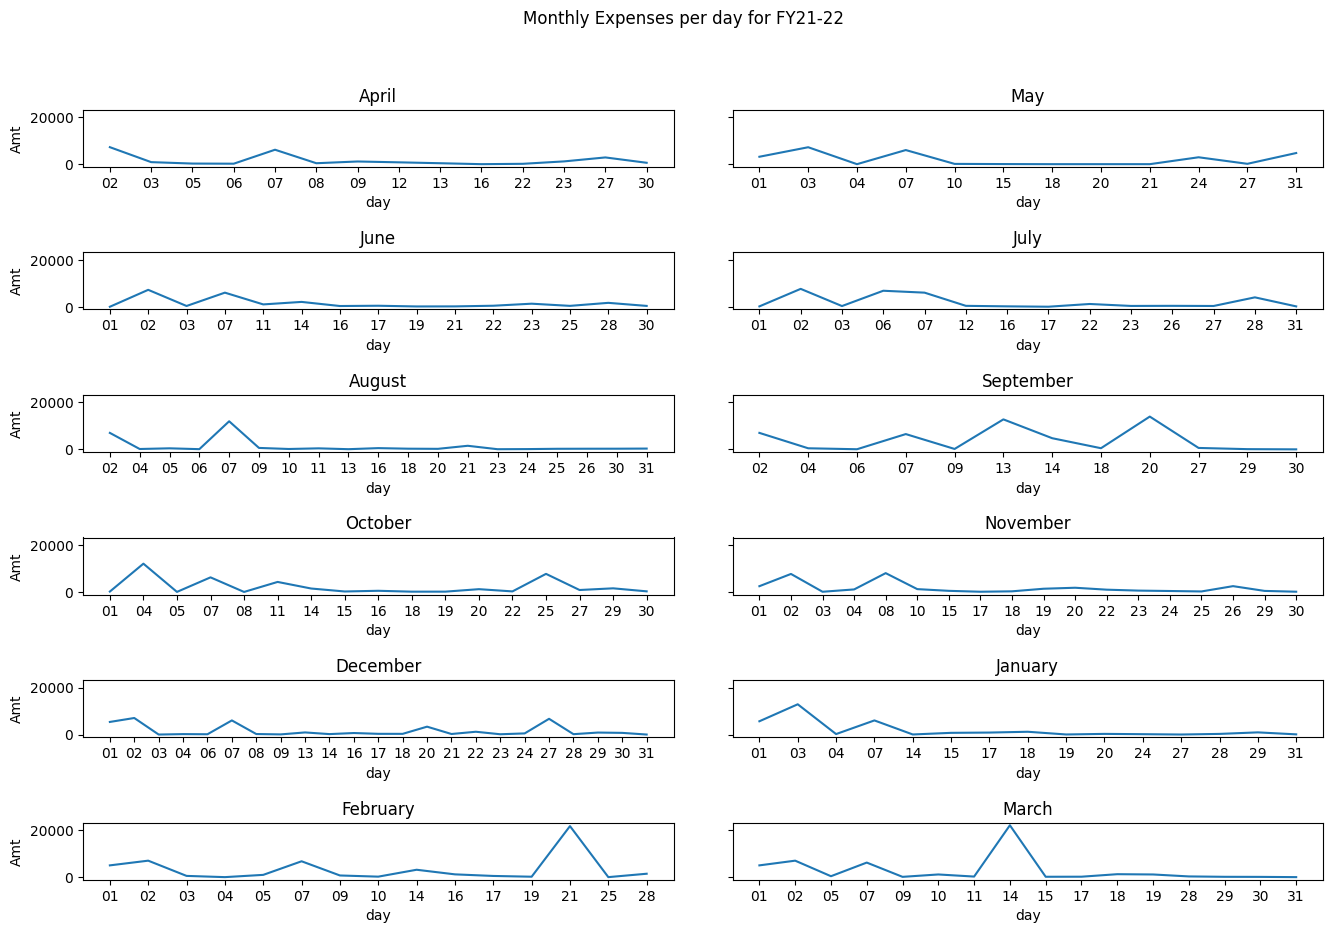

In [8]:
## This code will plot the Monthly expenses per day that occured for FY21-2022.
exp_df = data[expense_cols]

df = exp_df.groupby(["Transaction Date"])["Withdrawal Amount"].sum().reset_index()
df["day"] = df["Transaction Date"].dt.strftime('%d')
df['month'] = df["Transaction Date"].dt.month_name()

fig, ax = plt.subplots(nrows=6, ncols=2,figsize=(16,10),sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=1.5)

for i,ax in enumerate(ax.flatten()):
    if i <= 12:        
        sns.lineplot(x='day', y='Withdrawal Amount',data=df[df["month"]==months[i]],ax=ax)
        ax.set_title(months[i])
        ax.set_ylabel("Amt")
    else:
        ax.set_visible(False)
        
plt.suptitle("Monthly Expenses per day for FY21-22")
plt.show()

Expense range analysis: <br>

Here I will be binning the expenses from 1 to 1000 INR and wrapping up the outliers in a separate bin.
The countplot will help to analyse which range of expenses I occur the most.

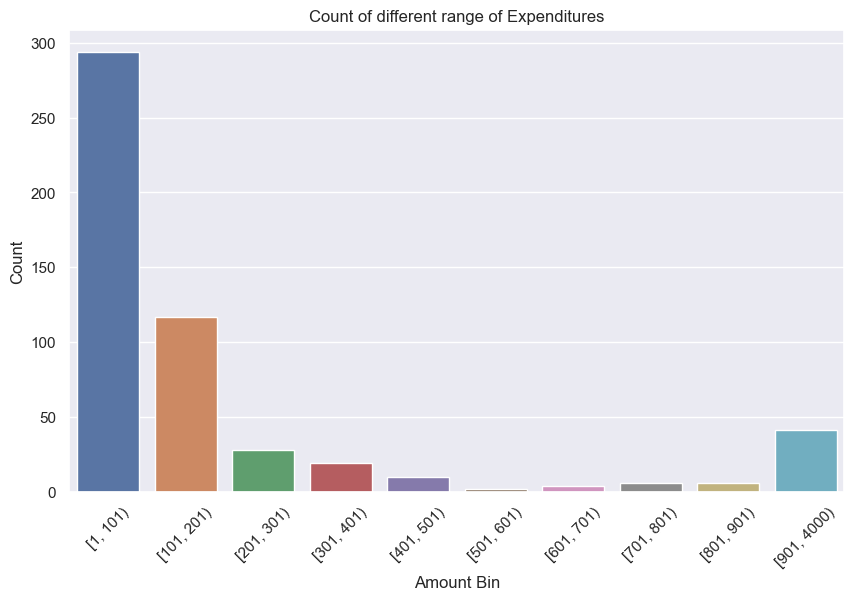

In [9]:
threshold = config.get("monthly_exp_threshold") ##Get the hardcoded threshold from config file.
exclude_type = config.get("mf") 

exp_df = data[expense_cols]

#Since my mutual funds investments are not really expenses, I will be removing them.
exp_df = exp_df[~exp_df["tnx_type"].isin(exclude_type)]

# Dropping amount 0 as these are credited values.
exp_df = exp_df[exp_df["Withdrawal Amount"] != 0]

# Since my monthly expenses rarely occur in large amounts, I have kept a threshold. Removing all the values beyond the threshold
exp_df = exp_df[exp_df["Withdrawal Amount"] <= threshold]

bin_edges = list(range(1,1000,100))
## Adding the threshold value to the edge. This is to make sure to wrap up any outlier value in this bin.
bin_edges.append(threshold) 

# Bin the amounts
exp_df['Amount Bin'] = pd.cut(exp_df['Withdrawal Amount'], bins=bin_edges, right=False)

# Set the plot style
sns.set(style="darkgrid")
# Create the countplot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(data=exp_df, x='Amount Bin')

# Set the labels and title
plt.xlabel('Amount Bin')
plt.ylabel('Count')
plt.title('Count of different range of Expenditures')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)
# Show the plot
plt.show()

Observation: <br>
1. The bins here indicate the amount of money involved.
2. I have a large number of transactions that are less than 100 INR. These expenses are mostly going for a snack or quick shopping.
3. Sometime expenses like groceries, eating out with friends or fast food costs me a bit more, thus observing more values in the 100 to 300 region.
4. I pay the utilities bills, so wifi, electricity, water etc lies in the 1000+ range.

---

### Investment Analysis

My investments are mostly of Mutual funds and my only source of income is my job 🥺

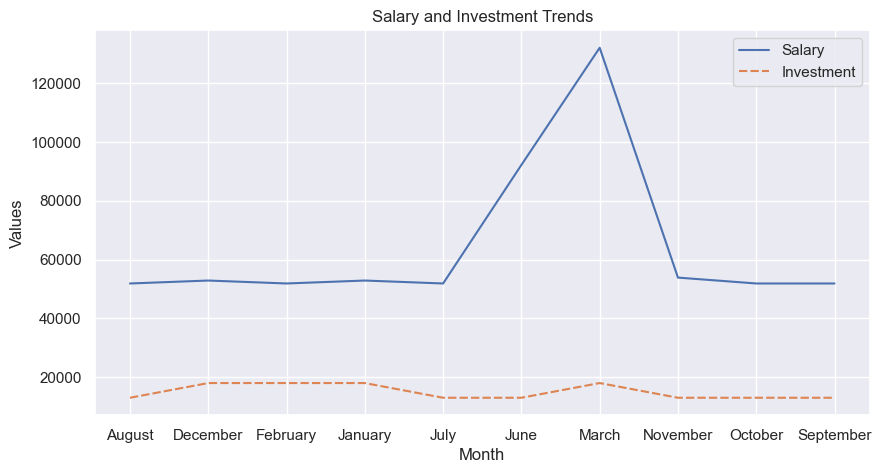

In [10]:
amount_columns = ['Withdrawal Amount', 'Deposit Amount', 'Month']

# Filter the data for salary transactions
salary_data = data[data["tnx_type"] == "Salary"][amount_columns]
# Filter the data for investment transactions
investment_data = data[(data["tnx_type"] == "External MF") | (data["tnx_type"] == "Internal MF")][amount_columns]
# Calculate the monthly salary total
monthly_salary = salary_data.groupby(salary_data["Month"]).sum()["Deposit Amount"]
# Calculate the monthly investment total
monthly_investment = investment_data.groupby(investment_data["Month"]).sum()["Withdrawal Amount"]
# Combine the monthly salary and investment totals into a dataframe
investment_dataframe = pd.concat([monthly_salary, monthly_investment], axis=1)
investment_dataframe.columns = ["Salary", "Investment"]
investment_dataframe["inv_perc"] = round(investment_dataframe["Investment"] / investment_dataframe["Salary"], 3)
# Remove unnecessary months from the dataframe
investment_dataframe.drop(["April", "May"], inplace=True)
# Select the columns for the final dataframe
final_dataframe = investment_dataframe[["Salary", "Investment"]]
# Create a line plot of the salary and investment trends
plt.figure(figsize=(10, 5))
sns.lineplot(data=final_dataframe)
plt.xlabel('Month')
plt.ylabel('Values')
plt.title('Salary and Investment Trends')
plt.show()

---

### Spending Behaviour Clustering

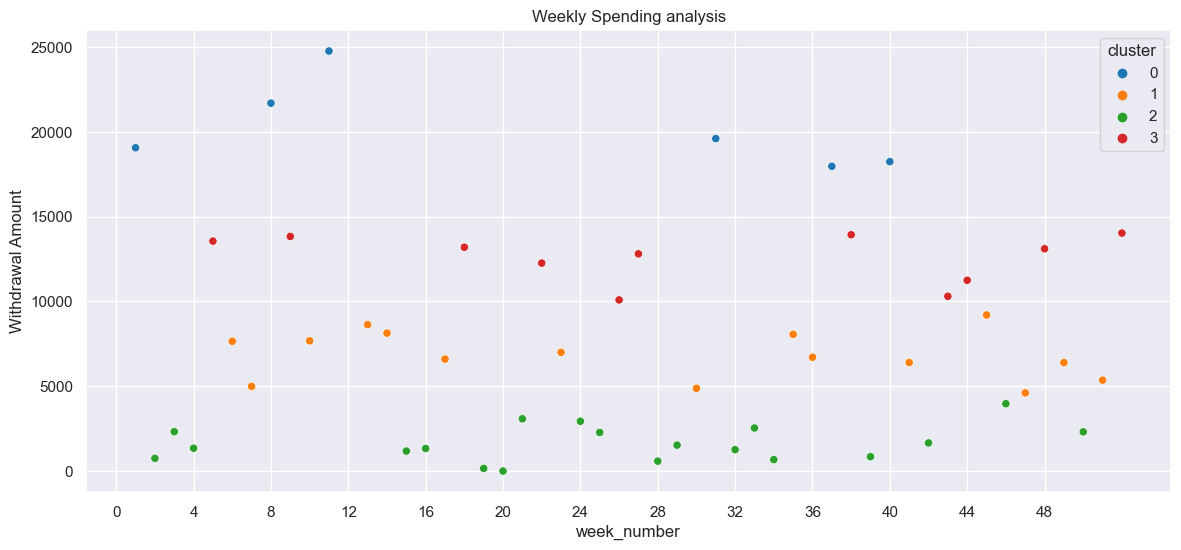

In [11]:
# Clustering of weekly expenses

# Load your spending data into a pandas DataFrame
df = data[["Transaction Date", "Withdrawal Amount"]]
# Extract the week number from the date column
df['week_number'] = df['Transaction Date'].dt.week
# Group the data by week number and calculate the total debit amount for each week
weekly_spending = df.groupby('week_number')['Withdrawal Amount'].sum().reset_index()
# Select the features you want to use for clustering (weekly spending)
df = weekly_spending[['Withdrawal Amount']]
# Preprocess and normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df)
# Define the range of cluster numbers to consider
n_clusters_range = range(2, 10)
# Perform K-means clustering for each cluster number and evaluate the silhouette score
best_silhouette_score = -1
best_n_clusters = None
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(normalized_data)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(normalized_data, cluster_labels)
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters
 # Perform clustering with the best number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
kmeans.fit(normalized_data)
cluster_labels = kmeans.labels_
# Add the cluster labels to the weekly spending DataFrame
weekly_spending['cluster'] = cluster_labels
# Generate a set of distinct colors from the 'tab10' color map
plt.figure(figsize=(14, 6))
c_map = sns.color_palette('tab10', n_colors=best_n_clusters)
sns.scatterplot(x=weekly_spending["week_number"], y=weekly_spending["Withdrawal Amount"], hue=weekly_spending["cluster"], palette=c_map)
plt.xticks(range(0, 52, 4))
plt.title("Weekly Spending analysis")
plt.show()

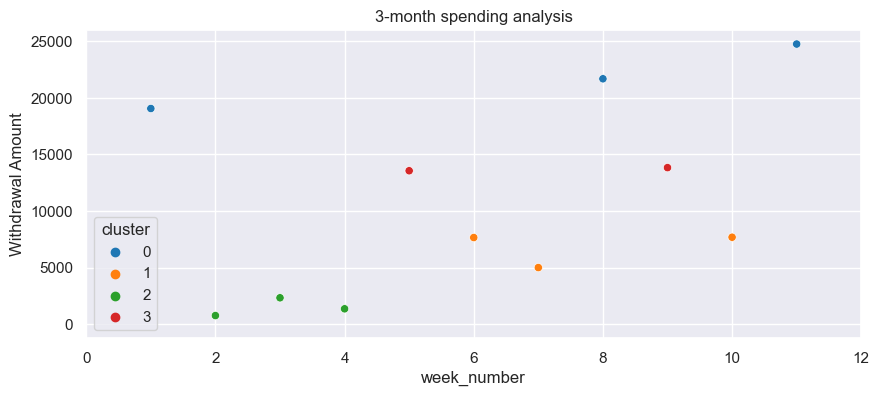

In [12]:
## Analysis of first 12 weeks.
plt.figure(figsize=(10, 4))
sns.scatterplot(x=weekly_spending["week_number"], y=weekly_spending["Withdrawal Amount"], hue=weekly_spending["cluster"], palette=c_map)
plt.xlim(0,12)
plt.title("3-month spending analysis")
plt.show()

<h4> Observations: </h4>
The above scatterplot shows the spending per week for the first 12 weeks.

- The highest expenditures happen in the first week itself.
    - These are mostly SIP, money I might owe, rent, and transferring money to savings bank.
- The following weeks are lower as these are small expenses, travelling, groceries, eating out etc
- Once in a while, the expenditure shoots up but does not exceed more tha Rs. 10000/- in a week

---

### Seasonality Analysis of Expenses

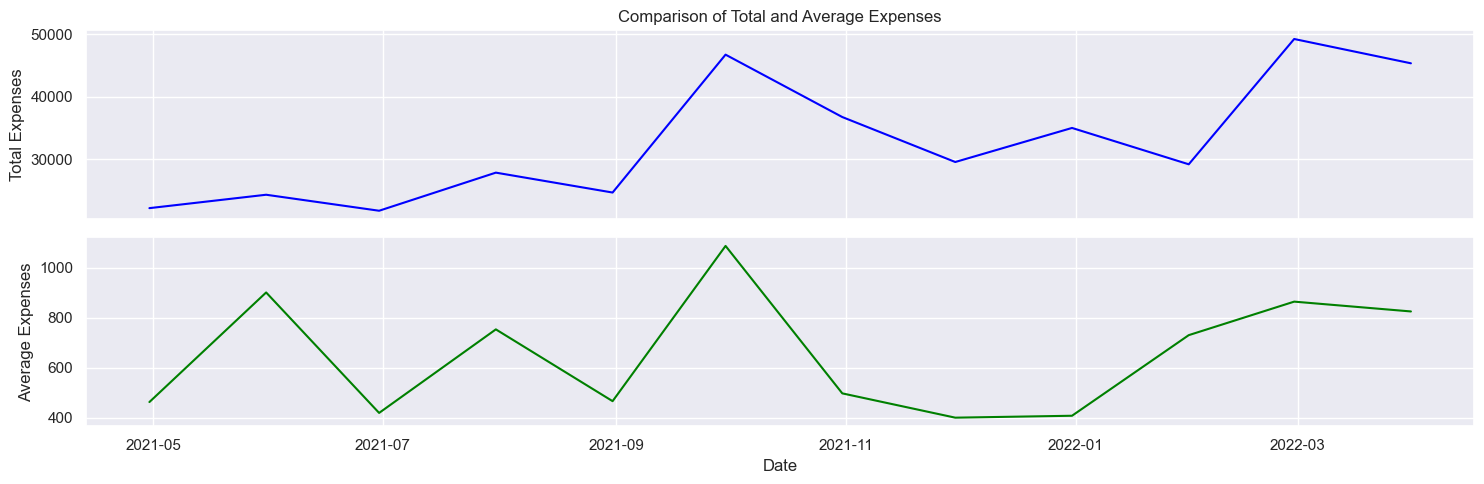

In [13]:
df = data[["Transaction Date", "Withdrawal Amount"]]
# Set the 'date' column as the DataFrame index
df.set_index('Transaction Date', inplace=True)

# Resample the data by month and calculate the total debit amount for each month
monthly_total_debit = df['Withdrawal Amount'].resample('M').sum()
monthly_mean_debit = df['Withdrawal Amount'].resample('M').mean()

# Create the plot
fig, axes = plt.subplots(2, 1, figsize=(15,5), sharex=True)
# Plot the total expenses with blue color
sns.lineplot(x=monthly_total_debit.index, y=monthly_total_debit.values, color='blue', ax=axes[0])
axes[0].set_ylabel('Total Expenses')
axes[0].set_title('Comparison of Total and Average Expenses')

# Plot the average expenses with green color
sns.lineplot(x=monthly_mean_debit.index, y=monthly_mean_debit.values, color='green', ax=axes[1])
axes[1].set_ylabel('Average Expenses')
axes[1].set_xlabel('Date')
# Show the plot
plt.tight_layout()
plt.show()

Due to lack of data currently accross multiple years, it is difficult to ascertain whether there are spike in expenses across each month.

### Inference:

![OpenAI Logo](mai-garib-hu.gif)
